# PINN Solver for Hernquist profile

## 1. Introduction
We start from the Hernquist density profile $$\rho(r) = \dfrac{M}{2\pi}\dfrac{a}{r}\dfrac{1}{(r+a)} $$

For such a potential, the Poisson equation reads:
$$\nabla ^2 \phi = 4\pi G \rho$$

$$ \Leftrightarrow \dfrac{1}{r^2} \dfrac{\partial}{\partial r}\left(r^2 \dfrac{\partial \phi}{\partial r}\right) = 4\pi G \left[\dfrac{M}{2\pi}\dfrac{a}{r}\dfrac{1}{(r+a)}\right]$$

Given that the density-potential pair depends solely on the radial coordinate $r$, the equation reduces to
$$  \dfrac{1}{r} \dfrac{d}{d r}\left(r^2 \dfrac{d \phi}{d r}\right) = \dfrac{2GMa}{a^3(\frac{r}{a}+1)^3}$$


Setting $r \rightarrow \frac{r}{a}$, we get
$$  \dfrac{d}{d r}\left(r^2 \dfrac{d \phi}{d r}\right) = \dfrac{2GM}{a}\dfrac{r}{(r+1)^3}$$


Finally, in the case of the Hernquist profile, the Poisson equation can be written such as:

$$ \boxed{\dfrac{d}{d r}\left(r^2 \dfrac{d \phi}{d r}\right) = \dfrac{2r}{(r+1)^3}}$$

where we have set $\frac{GM}{a}$ to unity.

By [integrating Poisson's equation](/analytical_potential_hernquist.ipynb), we find for this non dimensional equation :

$$ \Phi(s) = -\dfrac{1}{s + 1} $$ where $s=\dfrac{r}{a}$.

## 2. Implementation of the Physics-Informed Neural Network

We implement a simple neural network with one hidden layer (to start with), which outputs a single value. The latter value corresponds to the amplitude of the field at the point of interest. 

### 2.1 The Neural Network

We use here a Feedforward Neural Network (FFNN). The input layer takes one co-location point as an input. It has one hidden layer composed of 100 neurons, and outputs the amplitude of the field at this point. The neural network is here used as a universel function approximator. We use for the activation function the hyperbolic tangent. 

Several architectures will be tried out for the FFNN: 

|Number of layers| Number of Neurons (per layer) | Activation function  | Article  | 
|----------------|-------------------------------|----------------------|----------|
|   2-4 layers   |   32 and 50 neurons           |                      |          |
|   5-8 layers   |   250 neurons                 |                      |          |
|   9+  layers   |   20 neurons                  |                      |          |

### 2.2 The Loss Function

As stated, the model is trained by minimizing the loss function. In the case of Physics-Informed Neural Networks (PINNs), the loss function can be written in a general way as :

$$ \mathcal{L}(\theta) = \omega_{\mathcal{F}}\mathcal{L}_{\mathcal{F}}(\theta) + \omega_{\mathcal{B}}\mathcal{L}_{\mathcal{B}}(\theta) + \omega_{\mathcal{d}}\mathcal{L}_{data}(\theta)$$ 
where $\theta$ are the parameters of the neural network, and 
$$\mathcal{L}_{\mathcal{F}}(\theta) = MSE_{\mathcal{F}} = \dfrac{1}{N_c}\sum^{N_c}_{i=1} \left\|\mathcal{F}(\hat{u}_{\theta}(z_i)) - f(z_i)\right\|^2$$ represents the loss produced by a mismatch with the governing differential equation $\mathcal{F}$.

Similarly we have the following expression for the boundary loss :

$$\mathcal{L}_{\mathcal{B}}(\theta) = MSE_{\mathcal{B}} = \dfrac{1}{N_B}\sum^{N_B}_{i=1} \left\|\mathcal{B}(\hat{u}_{\theta}(z_i)) - g(z_i)\right\|^2$$

$N_c$ and $N_B$ represent the number of collocation and boundary points, respectively. 

$\mathcal{L}_{data}(\theta)$ is the loss with respect to the data points:

$$\mathcal{L}_{data}(\theta) = MSE_{data} = \dfrac{1}{N_d}\sum^{N_d}_{i=1} \left\|\hat{u}_{\theta}(z_i)) - u^{*}_i\right\|^2$$

Note that the quantity $r_{\mathcal{F}}[\hat{u}_{\theta}](z) = r_{\theta} (z) := \mathcal{F}(\hat{u}_{\theta}(z_i); \gamma) - f(z_i)$ is the differential equation residual. Similarly, the residual NN corresponding to boundary conditions is $r_{\mathcal{B}}[\hat{u}_{\theta}](z) = r_{\theta} (z) := \mathcal{B}(\hat{u}_{\theta}(z)) - g(z)$ [[1](https://doi.org/10.1007/s10915-022-01939-z)].

**Loss function for the Poisson equation**

In our case, we do not consider any data points. Therefore $N_d$ = 0 and $\mathcal{L}_{data}(\theta)=0$. Also we consider for now that $\omega_{\mathcal{F}} = \omega_{\mathcal{B}} = 1$. Finally, we consider in the training a 1-D domain, with $N_c = 1000$ and $N_B = 1$. <font color='red'>Note: Should we consider external boundary condition, and not solely the initial one ?</font>

We note that here, the residual $r_{\theta} (z)$ is as follow :

$$ r_{\theta} (z) = \dfrac{d}{d r}\left(r^2 \dfrac{d \phi}{d r}\right) - \dfrac{2r}{(r+1)^3}$$

Therefore, we want to minimize the following loss function :

$$ \mathcal{L}(\theta) = \dfrac{1}{N_c}\sum^{N_c}_{i=1} \left\|\dfrac{df}{d r} - \dfrac{2r_i}{(r_i+1)^3} \right\|^2 + \dfrac{1}{N_B}\sum^{N_B}_{i=1} \left\|\hat{\Phi}(z_0) - \Phi_0 \right\|^2$$ 

<font color='red'>Unclear to me what the $\mathcal{B}$ operator and the boundary function $g$ are.</font>
where we set $f = r^2 \dfrac{d \phi}{d r}$. 

**Boundary conditions:** We create a domain for which $r \in [a; b]$.
Hernquist shows that by integrating the aforementionned Poisson equation, one gets that:

$$ \Phi(r) = - \dfrac{GM}{r + a}$$

Let us recall that we have set $\frac{GM}{a} = 1$, meaning that $GM=a$. Therefore, in our case we should rewrite the potential such as :

$$ \Phi(r) = - \dfrac{a}{r + a}$$

In [1]:
import torch
from torch import nn, optim
import numpy as np
from tqdm.notebook import tqdm, trange

**Implementation of the Neural Network**

In [2]:
class NeuralNet(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):
        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)])
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)

**Implementation of the derivatives for the loss function**

In [50]:
def pde_residual(net, x):
    phi_pred = net(x)
    phi_x = torch.autograd.grad(phi_pred, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True,)[0]
    phi_x *= x ** 2
    df = torch.autograd.grad(phi_x, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True,)[0]
    residual = df - 2 * x / (x + 1) ** 3
    return residual.pow(2).mean()


def boundary_error(net, x_b, y_true):
    phi_pred = net(x_b)
    error = y_true - phi_pred
    return error.pow(2).mean()

def loss_function(net, x, x_b, y_true):
    return pde_residual(net, x) + boundary_error(net, x_b, y_true)

**Implementation of the loss function**

**Implementation of the training phase**

In [51]:
class TrainingPhase:
    def __init__(self, neural_net, domain, n_epochs, optimizer, _loss_function, x_train, y_train):
        self.neural_net = neural_net
        self.domain = domain
        self.n_epochs = n_epochs
        self.optimizer = optimizer
        self.loss_function = _loss_function
        self.x_train = x_train
        self.y_true = y_train

    def train_model(self):
        opt = self.optimizer(self.neural_net.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                           mode='min',
                                                           factor=0.5,
                                                           patience=1000,
                                                           threshold=0.0001,
                                                           verbose=True)
        loss = self.loss_function

        losses = []
        epochs = []
        for epoch in trange(self.n_epochs, desc="Epoch"):

            opt.zero_grad()
            loss_value = loss(self.neural_net, self.domain, self.x_train, self.y_true)
            loss_value.backward()
            opt.step()

            losses.append(loss_value.item())
            # if epoch % 100 == 0:
                # print("Époque : ", epoch, "Loss:", loss_value.item())
        return self.neural_net, np.array(epochs), np.array(losses)

    def save_model(self, filename):
        torch.save(self.neural_net, filename)

**Training the Model**

In [86]:
def analytic_prediction(r, _a):
    """ Value of the gravitational potential 
        in the case of an Hernquist profile 
    """
    return -1/(r + 1)

# PARAMETERS
n_epochs = 50_000
a = 1.0
NUM_HIDDEN_LAYERS = 2
DIM_HIDDEN_LAYERS = 32

pinn = NeuralNet(num_hidden=NUM_HIDDEN_LAYERS, dim_hidden=DIM_HIDDEN_LAYERS, act=nn.Tanh())
print("Training Neural Network :", pinn)

# Initial conditions
x0 = 0.0
f0 = analytic_prediction(x0, a)
xf = 1000
ff = analytic_prediction(xf, a)
# Domain
s = torch.linspace(x0, xf, 1000, requires_grad=True)
s = s.reshape(-1, 1)

x_train = torch.Tensor([x0, xf]).reshape(-1, 1)
y_train = torch.Tensor([f0, ff]).reshape(-1, 1)

training = TrainingPhase(neural_net=pinn, domain=s, n_epochs=n_epochs, 
                         optimizer=optim.Adam,_loss_function=loss_function, x_train=x_train, y_train=y_train)

net, epochs, losses = training.train_model()
# training.save_model(f"resultats/Hernquist_{n_epochs}.pt")

Training Neural Network : NeuralNet(
  (layer_in): Linear(in_features=1, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (middle_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (act): Tanh()
)


Epoch:   0%|          | 0/50000 [00:00<?, ?it/s]

In [83]:
testing_domain = torch.linspace(0, 1000, 10000, requires_grad=False) * a
y_true = analytic_prediction(testing_domain.numpy(), a)
y_pred_plot = phi(net, testing_domain.reshape(-1, 1)).ravel()

# np.save("resultats/analytical_Hernquist.npy", y_true)
# np.save("resultats/computed_Hernquist.npy", y_pred_plot.detach().numpy())
# np.save("resultats/loss.npy", losses)

**Plotting the results**  
This part can be run independently from the rest of the notebook, if the model has already been trained once. Indeed the results are saved so the model does not have to be trained each time. To do so, go below to the "[Plotting using pre-trained model" section](#Plotting-using-pre-trained-model).

In [84]:
import numpy as np
import matplotlib.pyplot as plt

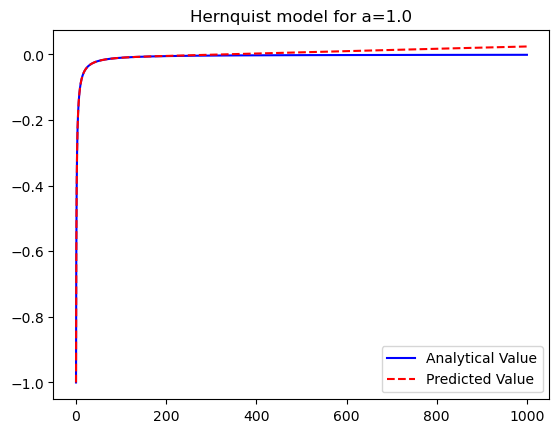

In [85]:

plt.figure()
plt.title(f"Hernquist model for {a=}")
plt.plot(testing_domain.numpy(), y_true, 'b', label="Analytical Value")
plt.plot(testing_domain.numpy(), y_pred_plot.detach().numpy(), '--r', label="Predicted Value")
# plt.plot(s.detach().numpy(), y_pred_train.detach().numpy(),'.k', label="Predicted 2")
# plt.savefig(f"resultats/Predicttion_{NUM_HIDDEN_LAYERS}x{DIM_HIDDEN_LAYERS}_linear.png")
plt.legend();

In [75]:
def relative_error(domain, y_pred, y_true, plot=False, save=False):
    result = (y_pred - y_true) / y_true
    if not plot:
        return result

    plt.figure()
    plt.title(r"Relative error $\dfrac{\Delta \phi}{\phi}$")
    plt.plot(domain, result)
    if save:
            plt.savefig(f"Relative_error_hernquist_{a=}.png")
    plt.show()
    return result

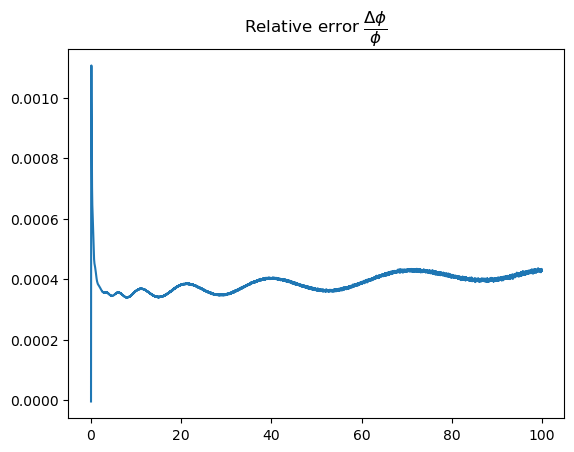

In [76]:
relat_err = relative_error(domain=testing_domain, y_pred=y_pred_plot.detach().numpy(), y_true=y_true, plot=True, save=True)

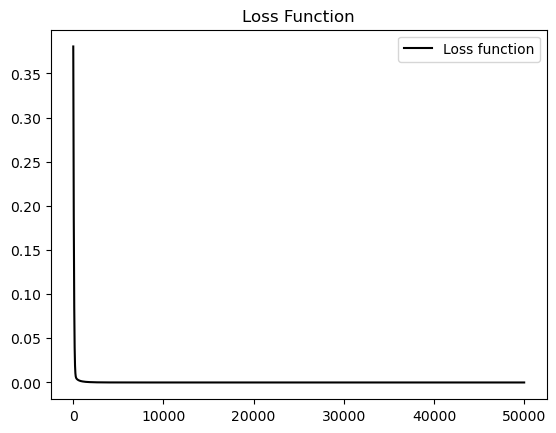

In [69]:
plt.figure()
plt.title("Loss Function")
plt.plot(np.arange(n_epochs), losses, 'k', label="Loss function")
# plt.yscale("log")
plt.legend();
#plt.savefig(f"resultats/Loss_{NUM_HIDDEN_LAYERS}x{DIM_HIDDEN_LAYERS}_linear.png")

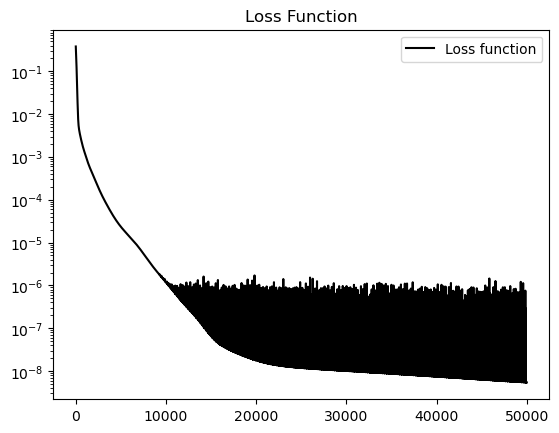

In [70]:
plt.figure()
plt.title("Loss Function")
plt.plot(np.arange(n_epochs), losses, 'k', label="Loss function")
plt.yscale("log")
plt.legend()
#plt.savefig(f"resultats/Loss_{NUM_HIDDEN_LAYERS}x{DIM_HIDDEN_LAYERS}_log.png")

### Plotting using pre-trained model

In [5]:
# to load the model if necessary
import torch
trainedNN = torch.load("resultats/Hernquist1.pt") # or other Hernquist_...pt files

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def analytic_prediction(r, _a):
    """ Value of the gravitational potential 
        in the case of an Hernquist profile 
    """
    return -1/(r + _a)

In [12]:
# to use saved results for the hernquist potential
a = 1.0
y_true = np.load("resultats/analytical_Hernquist.npy")
y_pred_plot = np.load("resultats/computed_Hernquist.npy")

s = torch.linspace(0.01, 10, 1000, requires_grad=True)
s = s.reshape(-1, 1)  * a
s_plot = torch.linspace(0.1, 10, 1000, requires_grad=False) * a# Testing domain ?

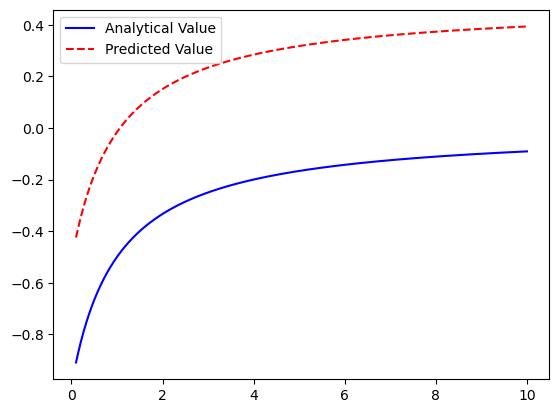

In [13]:

y_true = analytic_prediction(s_plot.detach().numpy(), a)
plt.figure()
plt.plot(s_plot.detach().numpy(), y_true, 'b', label="Analytical Value")
plt.plot(s_plot.detach().numpy(), y_pred_plot, '--r', label="Predicted Value")
# plt.plot(s.detach().numpy(), y_pred_train.detach().numpy(),'.k', label="Predicted 2")
#plt.savefig(f"resultats/Predicttion_{NUM_HIDDEN_LAYERS}x{DIM_HIDDEN_LAYERS}_linear.png")
plt.legend();

# plt.figure()
# plt.title("Loss Function")
# plt.plot(np.arange(n_epochs), losses, 'k', label="Loss function")
# plt.yscale("log")
# plt.legend()
# plt.savefig(f"resultats/Loss_{NUM_HIDDEN_LAYERS}x{DIM_HIDDEN_LAYERS}_linear.png")

# plt.figure()
# plt.title("Loss Function")
# plt.plot(np.arange(n_epochs), losses, 'k', label="Loss function")
# plt.yscale("log")
# plt.legend()
#plt.savefig(f"resultats/Loss_{NUM_HIDDEN_LAYERS}x{DIM_HIDDEN_LAYERS}_linear.png")